Libraries

In [ ]:
pip install rasterio
import rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.0 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from PIL import ImageOps
import numpy as np
import warnings
from skimage.morphology import skeletonize
from skimage.filters import median
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from PIL import ImageFilter
import os
import cv2
from collections import defaultdict
import shutil
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MetaData Check

In [ ]:
with rasterio.open('/content/mndwi.tif') as dataset:
    # Get the number of bands (layers)
    num_bands = dataset.count
    print(f'The number of layers (bands) in the GeoTIFF is: {num_bands}')

The number of layers (bands) in the GeoTIFF is: 1


In [ ]:
def check_for_warnings(img_array):
    # Function to catch runtime warnings and identify problematic values
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")  # Turn warnings into exceptions

            # Example operation that could trigger a runtime warning
            # (e.g., invalid comparison or division by zero)
            for i in range(img_array.shape[0]):
                for j in range(img_array.shape[1]):
                    # An example operation where warnings may occur
                    # We simulate a warning-causing operation: comparison of NaN, or other invalid float ops
                    if img_array[i][j] > 0:
                        pass  # Do something, e.g., inversion logic
                    elif img_array[i][j] <= 0:
                        pass  # Handle the non-positive case

    except RuntimeWarning as e:
        print(f"RuntimeWarning occurred: {e}")
        # Trace problematic values in the array
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                if np.isnan(img_array[i][j]):
                    print(f"Found NaN at position: ({i}, {j})")
                elif np.isinf(img_array[i][j]):
                    print(f"Found infinity at position: ({i}, {j})")
                elif img_array[i][j] <= 0:
                    print(f"Found non-positive value {img_array[i][j]} at position: ({i}, {j})")


In [ ]:
with Image.open('/content/NDVI_1988_01_05.tif') as img:
        img_array = np.array(img)
        print(img_array.shape)
        print(img_array.dtype)
        check_for_warnings(img_array)

(113, 302)
float32


# Convert GeoTiff to PNG

In [ ]:
def geotiff_to_grayscale_png(input_tiff_path, output_png_path):
    # Open the GeoTIFF file
    with rasterio.open(input_tiff_path) as dataset:
        # Read the first band (or select another band if needed)
        band1 = dataset.read(1)

        # Normalize the data to the range 0-255 for PNG
        band_min, band_max = band1.min(), band1.max()
        print(f"Band Min: {band_min}, Band Max: {band_max}")

        # Avoid division by zero by ensuring band_max != band_min
        if band_max > band_min:
            normalized_band = ((band1 - band_min) / (band_max - band_min)) * 255
        else:
            normalized_band = np.zeros_like(band1)  # Handle the case of a constant band

        # Convert to uint8 type (0-255 range for grayscale)
        normalized_band = normalized_band.astype(np.uint8)

        # Create a grayscale image using PIL
        img = Image.fromarray(normalized_band, mode='L')  # 'L' mode is for grayscale images

        # Save the image as PNG
        img.save(output_png_path)

        print(f"Grayscale PNG saved to {output_png_path}")

In [ ]:
def geotiff_to_grayscale_png_landsat5(input_path, output_path):

    with rasterio.open(input_path) as src:
        try:
          ndwi_data = src.read(1)

          ndwi_data = np.nan_to_num(ndwi_data, nan=-1, posinf=-1, neginf=-1)

          # Normalize the values to 0-255
          ndwi_normalized = np.clip((ndwi_data + 1) * 127.5, 0, 255).astype(np.uint8)

          # Save as PNG
          Image.fromarray(ndwi_normalized).save(output_path)


        except Exception as e:
          print(f'could not convert {e}')

In [ ]:
image_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_export_py2'

images=os.listdir(image_folder)

for i in images:
    output_path=i.split('.')[0].split('/')[-1]
    output_path=os.path.join('/content/drive/MyDrive/GEE_Exports_Indice/GEE_PNG', f'{output_path}_grayscale.png' )

    input=os.path.join(image_folder, i)
    try:
      geotiff_to_grayscale_png_landsat5(input, output_path )
    except Exception as e:
      print(f'could not convert {e}')


# Process PNG

In [ ]:
def scale(image_folder, output_folder):
  images=os.listdir(image_folder)

  for i in images:
    try:
      img=cv2.imread(os.path.join(image_folder, i), cv2.IMREAD_GRAYSCALE)
      scale_factor = 12

      height, width = img.shape[:2]

      new_width = width * scale_factor
      new_height = height * scale_factor

      resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

      cv2.imwrite(os.path.join(output_folder, i), resized_img)
    except Exception as e:
      print(f'could not scale {i} \n {e}')
      return -1

In [ ]:
scale('/content/drive/MyDrive/GEE_Exports_Indice/GEE_export_py2_output','/content/drive/MyDrive/GEE_Exports_Indice/GEE_Scaled')

In [ ]:

def invert_ndvi(input_image_path, output_image_path):
    images = os.listdir(input_image_path)

    for i in images:
        # Process only NDVI images before 2013
        if str(i).split('.')[0].split('/')[-1].split('_')[0] == 'NDVI' and int(str(i).split('.')[0].split('/')[-1].split('_')[1]) < 2013:

            # Open the image
            img = Image.open(os.path.join(input_image_path, i)).convert('L')  # Convert to grayscale

            # Calculate the percentage of white pixels
            white_pixel_count = sum(1 for pixel in img.getdata() if pixel > 127)  # Assuming white > 127
            total_pixels = img.size[0] * img.size[1]
            white_pixel_percentage = (white_pixel_count / total_pixels) * 100

            # Check if white pixels are at least 70%
            if white_pixel_percentage >= 60:
                # Invert the image
                inverted_image = ImageOps.invert(img)
                inverted_image.save(os.path.join(output_image_path, i))
                print(f"Inverted and saved: {i}")


In [ ]:
def crop_landsat5_images(im_landsat5_path):
  images=os.listdir(im_landsat5_path)
  for i in images:
    try:
      if int(str(i).split('.')[0].split('/')[-1].split('_')[1]) < 2013:
        im_landsat5=cv2.imread(os.path.join(im_landsat5_path,i))
        if im_landsat5.shape[1]==1208:
          x, y, w, h = 8, 0, 1200, 452
          region_of_interest = im_landsat5[y:y+h, x:x+w]
          cv2.imwrite(i, region_of_interest)
    except:
      print(f"couldn't crop {i}")

In [ ]:
def crop_all(im_path):
  images=os.listdir(im_path)
  for i in images:
    try:
      image=cv2.imread(os.path.join(im_path,i))
      x, y, w, h = 576, 1024, 6384, 4016
      region_of_interest = image[y:y+h, x:x+w]
      cv2.imwrite(os.path.join(im_path,i), region_of_interest)
    except:
      print(f"couldn't crop {i}")

In [ ]:
crop_all('/content/drive/MyDrive/GEE_Exports_Indice/GEE_CherryPicked/GEE_Combined_Thresholded')

In [ ]:
def threshold_image(input_image_path, output_image_path):
    # Open the grayscale image
    try:
      image=cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

      ret,thresh2 = cv2.threshold(image,120,255,cv2.THRESH_BINARY)

      cv2.imwrite(output_image_path, thresh2)

    except Exception as e:
      print(f"couldn't threshold {input_image_path} {e}")
      print(output_image_path)


In [ ]:
def threshold_folder(image_paths, output_folder):
  for i in os.listdir(image_paths):
    im_path=os.path.join(image_paths, i)
    output_path=str(im_path).split('.')[0].split('/')[-1]
    threshold_image(im_path, os.path.join(output_folder,f'{output_path}.png'))


In [ ]:
def combine_images(image_paths, output_path, alpha=0.5):
    try:
      base_image = Image.open(image_paths[0]).convert('RGBA')

      combined_image = Image.new('RGBA', base_image.size)

      # Paste the base image into the combined image
      combined_image.paste(base_image, (0, 0))

      # Iterate through the rest of the images
      for image_path in image_paths[1:]:
          current_image = Image.open(image_path).convert('RGBA')
          combined_image = Image.blend(combined_image, current_image, alpha)
      file_name=os.path.basename(image_paths[0])
      date = '_'.join(file_name.split('.')[0].split('_')[1:4])
      combined_image.save(os.path.join(output_path, f'{date}.png'))
    except:
      print(f"couldn't combine {image_paths}")

In [ ]:
def sort_and_combine(image_directory, output_directory):
  images_by_date = defaultdict(dict)

  # Step 1: Group images by date
  for filename in os.listdir(image_directory):
      if filename.endswith(".png"):  # Process only PNG files
          parts = filename.split("_")  # Split the filename by underscores
          if len(parts) >= 4:
              # Extract the date and index by type
              date = "_".join(parts[1:4])  # Format: YYYY_MM_DD
              key_type = parts[0]  # NDVI, NDWI, MNDWI
              images_by_date[date][key_type] = os.path.join(image_directory, filename)

  # Step 2: Combine images for each date
  for date, image_files in images_by_date.items():
      if "NDVI" in image_files and "NDWI" in image_files and "MNDWI" in image_files:
          images=[image_files["NDVI"], image_files["NDWI"], image_files["MNDWI"]]
          combine_images(images, output_directory)

In [ ]:
def skeletonize_image(input_image_path, output_image_path):
  images=os.listdir(input_image_path)

  for i in images:
    try:
      img = Image.open(os.path.join(input_image_path, i)).convert('L')
      img_array = np.array(img)
      # Any pixel value > 200 will be treated as 1 (True), others as 0 (False)
      binary_image = img_array > 150
      skeleton = skeletonize(binary_image)
      # Convert the skeleton back to a PIL image (0s and 255s for black and white)
      skeleton_image = Image.fromarray((skeleton * 255).astype(np.uint8))
      skeleton_image.save(os.path.join(output_image_path, i))
    except Exception as e:
      print(f"couln't skeletonize {i}")
      print({e})
      return -1


In [ ]:
skeletonize_image('/content/drive/MyDrive/GEE_Exports_Indice/GEE_CherryPicked/GEE_Combined_Thresholded',
                  '/content/drive/MyDrive/GEE_Exports_Indice/Final Skeletons')

(greyscale ndvi had additional noise added when it was inverted without thresholding)

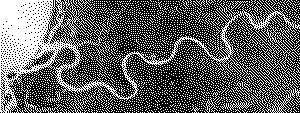

In [ ]:
def move_images(inverted_folder,cropped_folder ,final_folder):
  cropped_images=os.listdir(cropped_folder)
  for c in cropped_images:
    source=os.path.join(cropped_folder,c)
    destination=os.path.join(final_folder, c)
    shutil.move(source, destination)
    # print(c)

  ndvis=os.listdir(inverted_folder)
  for n in ndvis:
    source=os.path.join(inverted_folder,n)
    destination=os.path.join(final_folder, n)
    shutil.move(source, destination)
  #   print(n)


In [ ]:
def discard_large_noise(image_path, output_path):
  images=os.listdir(image_path)
  for im in images:
    image=cv2.imread(os.path.join(image_path, im))

    polygon_points=[(1640,1376), (720,3184),(3264, 4720),(6240, 5120),(7664, 4608),(11280, 3152),(14384, 1648),(14384, 352),(10944, 416)]

    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    polygon = np.array(polygon_points, dtype=np.int32)
    cv2.fillPoly(mask, [polygon], 255)

    masked_image = cv2.bitwise_and(image, image, mask=mask)

    cv2.imwrite(os.path.join(output_path, im), masked_image )


## Script


In [ ]:
png_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_Scaled'
thresholded_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_Thresholded'
inverted_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_Inverted'
final_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_final'
combined_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_Combined'
combined_thresholded='/content/drive/MyDrive/GEE_Exports_Indice/GEE_Combined_Thresholded'
final_skeleton_folder='/content/drive/MyDrive/GEE_Exports_Indice/GEE_Skeletons'

# crop_landsat5_images(png_folder)
# threshold_folder(png_folder, thresholded_folder)
invert_ndvi(thresholded_folder,inverted_folder)
move_images(inverted_folder,thresholded_folder ,final_folder)
sort_and_combine(final_folder,combined_folder)
discard_large_noise(combined_folder, combined_folder)
threshold_folder(combined_folder, combined_thresholded)
skeletonize_image(combined_thresholded,final_skeleton_folder)

In [ ]:
import numpy as np
from PIL import Image
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import cv2

def mark_centerline_and_banks(original_image_path, output_image_path):

    original_img = Image.open(original_image_path).convert('L')
    original_array = np.array(original_img)

    # Detect the banks (edges) from the original image
    edges = cv2.Canny(original_array, threshold1=100, threshold2=200)

    # Create an RGB image to visualize centerline and banks
    result_img = np.zeros((original_array.shape[0], original_array.shape[1], 3), dtype=np.uint8)

    # Mark banks as green
    result_img[edges > 0] = [0, 255, 0]  # Green for the banks

    # Convert back to an image and save
    result_pil = Image.fromarray(result_img)
    result_pil.save(output_image_path)

    print(f"Centerline and banks marked image saved at {output_image_path}")

In [ ]:
mark_centerline_and_banks('/content/MNDWI_1988_03_09.png','/content/banks.png')

Centerline and banks marked image saved at /content/banks.png


Before Inversion

  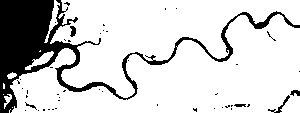

After inversion

  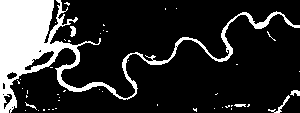

Combined Image

  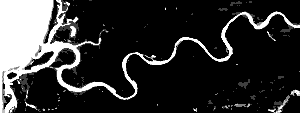

Skeleton

  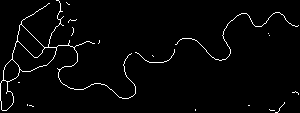

In [ ]:
def line_connector(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Binarize the image
  _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

  # Step 1: Morphological Closing
  kernel = np.ones((7, 7), np.uint8)
  closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

  # Step 2: Find and Bridge Contours
  contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour_image = closed_image.copy()

  for i, cnt in enumerate(contours):
      # Draw contours to bridge gaps
      cv2.drawContours(contour_image, [cnt], 0, (255), thickness=2)

  # Step 3: Skeletonize the Result
  thinned_image = cv2.ximgproc.thinning(contour_image)

  # Step 4: Save and Display
  output_path = 'fully_connected_image.png'
  cv2.imwrite(output_path, thinned_image)

  # Display the original and processed images
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.title("Original Image")
  plt.imshow(binary_image, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title("After Bridging Contours")
  plt.imshow(contour_image, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title("Skeletonized Final Image")
  plt.imshow(thinned_image, cmap='gray')
  plt.axis('off')

  plt.show()


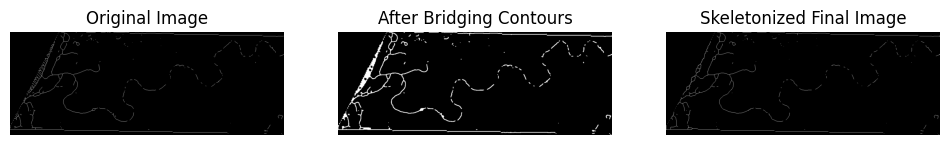

In [ ]:
line_connector('/content/combined_skeleton_base.png')

2015

  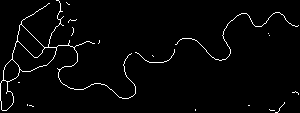

2003

  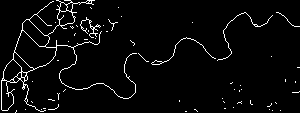


  Combined skeleton
  
  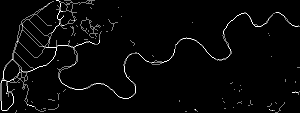

In [ ]:
sort_and_combine(final_folder,combined)

In [ ]:
def move(cropped_folder ,final_folder):
  cropped_images=os.listdir(cropped_folder)
  for c in cropped_images:
    source=os.path.join(cropped_folder,c)
    destination=os.path.join(final_folder, c)
    shutil.move(source, destination)

In [ ]:
move('/content/drive/MyDrive/GEE_Exports','/content/drive/MyDrive/GEE_Exports_Indice')

## Results for NDVI image with no inversion

NDVI GeoTiff to Grayscale PNG

 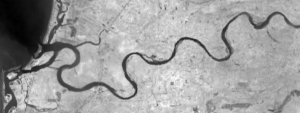

Grayscale image thresholded

  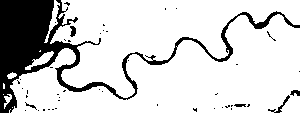

Blur applied for noise removal

(this was done because river skeleton wasnt clear with lots of interconnected regions)

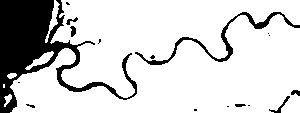


Skeletonized image (after noise removal)

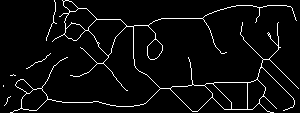

Applying a Gaussian blur beforehand resulted in fragmented river mask even with a lower threshold value (80)

  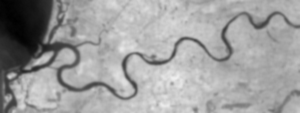

  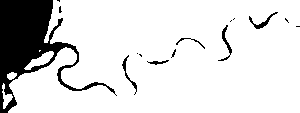

# Use Elevation to exclude sea and extract river path during dry season

# Process GeoTiff

In [ ]:

def invert_tiff(input_path, output_path):
    # Open the TIFF image
    with Image.open(input_path) as img:

        # images are in F mode and can't be written back in that mode
        # can't invert by converting to L mode

        img_array = np.array(img)
        print(img_array.shape)
        print(img_array.dtype)

        nan_mask = np.isnan(img_array)

        img_array[nan_mask] = 0.9

        inv_array=np.zeros_like(img_array, dtype=np.float32)
        print(inv_array.shape)
        print(inv_array.dtype)




        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                if img_array[i][j] > 0:
                    inv_array[i][j] = 255
                else:
                    inv_array[i][j] = 0

        inverted_image_tiff = Image.fromarray(inv_array.astype(np.float32))
        inverted_image = Image.fromarray(inv_array.astype(np.uint8))
        inverted_image.save(output_path)

        print(inverted_image.getbands())

        return inverted_image_tiff




In [ ]:
def threshold_tiff(input_path, output_path):
  with Image.open(input_path) as img:
    img_array = np.array(img)

    thresh_array = np.random.rand(img_array.shape[0], img_array.shape[1])
    img_array = np.nan_to_num(img_array)

    for i in range(img_array.shape[0]):
      for j in range(img_array.shape[1]):
        try:
          with warnings.catch_warnings():
            warnings.simplefilter("error")
            if img_array[i][j] > 0:
              thresh_array[i][j] = 255
            else:
              thresh_array[i][j] = 0
        except:
          print(i, j)

    thresh_image = Image.fromarray(thresh_array.astype(np.uint8))
    thresh_image.save(output_path)


In [ ]:
def combine_tiff_images(input_paths, output_path):

    images = [Image.open(path).convert('RGBA') for path in input_paths]

    # Find the maximum dimensions
    max_width = max(img.width for img in images)
    max_height = max(img.height for img in images)

    # Create a new blank image with the maximum dimensions
    combined_img = Image.new('RGBA', (max_width, max_height), (0, 0, 0, 0))

    # Paste and blend the images
    for img in images:
        # Resize the image to match the combined image size
        resized_img = img.resize((max_width, max_height), Image.LANCZOS)

        # Blend the current image with the combined image
        combined_img = Image.alpha_composite(combined_img, resized_img)

    combined_img_array = np.array(combined_img)
    print(combined_img_array.shape)
    print(combined_img_array.dtype)

    combined_image_png = Image.fromarray(combined_img_array.astype(np.uint8))
    combined_image_png.save(output_path)





    # # Save the combined image
    # combined_img.save(output_path)

In [ ]:
inv=invert_tiff('/content/ndvi.tif', "inverted_ndvi.png")


(113, 300)
float32
(113, 300)
float32
('L',)


In [ ]:
files=['/content/ndvi.tif','/content/ndwi.tif','/content/mndwi.tif']

for f in files:
  thresholded=threshold_tiff(f, f'{f}_thresholded.png')

In [ ]:
input_images = ['/content/thresholded.png', '/content/inverted_ndvi.png']
combine_tiff_images(input_images, "combined_image.png")

(113, 300, 4)
uint8


Result

  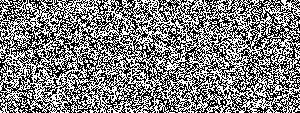